In [25]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [26]:
from fastai.vision import *

import IPython.display as ipd
from tqdm import tqdm_notebook

In [27]:
import re
pat = re.compile(r'.*/(\w+)_\w+_\d+\.jpg')


In [28]:
from pathlib import Path
import numpy as np

path_img = "mfc_data"
fnames = list(Path(path_img).rglob('*.jpg')) + list(Path(path_img).rglob('*.jpeg')) + list(Path(path_img).rglob('*.png'))
np.random.seed(42)
np.random.shuffle(fnames)
fnames[:5]


[Path('mfc_data/Female_SX88_6000.jpg'),
 Path('mfc_data/Female_SA2_5992.jpg'),
 Path('mfc_data/Female_SX333_3808.jpg'),
 Path('mfc_data/Male_SX188_3946.jpg'),
 Path('mfc_data/Female_SI1693_4514.jpg')]

['Female', 'Male']


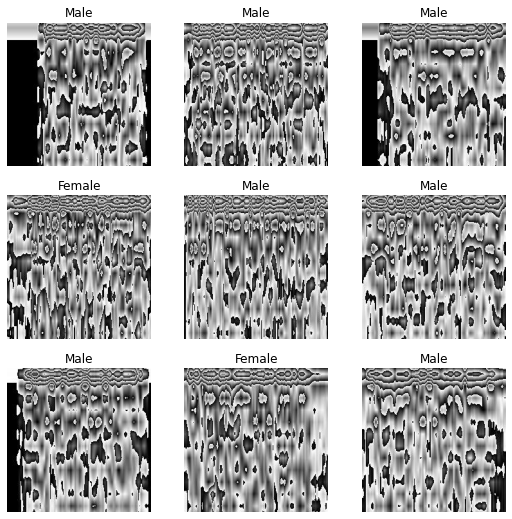

In [29]:
from fastai.vision.all import *
# Tạo DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=RegexLabeller(pat, match=1)
)

# Tạo DataLoaders
dls = dblock.dataloaders(path_img, bs=64)

# Hiển thị batch và classes
dls.show_batch()
print(dls.vocab)



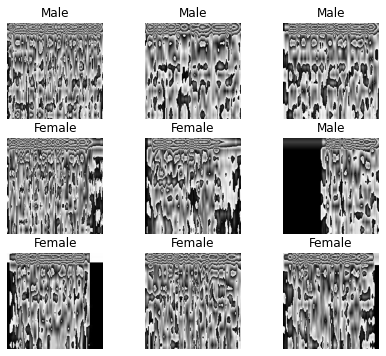

In [30]:
# Replace the old show_batch code with the following
dls.show_batch(nrows=3, ncols=3, figsize=(7,6))


In [31]:

learn = cnn_learner(dls, models.resnet34, metrics=error_rate)

# Provide the correct file path to the exported learner file
learner_path = "vgg16_step1.pkl"

# Load the learner model from the exported file
learn.model = load_learner(learner_path).model


In [32]:
interp = ClassificationInterpretation.from_learner(learn, ds_idx=1)  # Assuming validation data is at index 1



In [33]:
losses, idxs = interp.top_losses()  # only uses data from the validation set

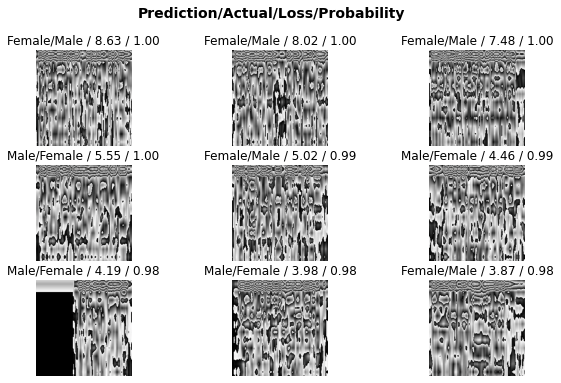

In [34]:
interp.plot_top_losses(9, figsize=(10, 6))


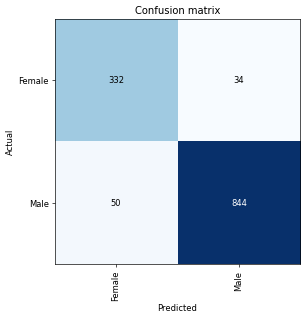

In [35]:
interp.plot_confusion_matrix(figsize=(5,6), dpi=60)

In [36]:
cmat = interp.confusion_matrix()
precision = cmat[0][0] / (cmat[0][0] + cmat[1][0])  # true positives / (true positives + false positives = positive predictions) 
recall = cmat[0][0] / (cmat[0][0] + cmat[0][1])  # true positives / (true positives + false negatives = positive ground truths)
f1_score = 2 / (1 / precision + 1 / recall)
accuracy = (cmat[0][0] + cmat[1][1]) / (cmat[0][0] + cmat[0][1] + cmat[1][0] + cmat[1][1])


In [37]:
precision

0.8691099476439791

In [38]:
recall

0.907103825136612

In [39]:
f1_score

0.8877005347593584

In [40]:
accuracy

0.9333333333333333

In [42]:
from sklearn.metrics import classification_report

# Get predictions and true labels
preds, targs = learn.get_preds(ds_idx=1)

# Convert predictions and true labels to class indices
preds_classes = preds.argmax(dim=1)
targs_classes = targs.int()

# Convert class indices to class labels using the DataLoader's vocab
preds_labels = [dls.vocab[i] for i in preds_classes]
targs_labels = [dls.vocab[i] for i in targs_classes]

# Generate classification report
class_report = classification_report(targs_labels, preds_labels)
error_rate = 1.0 - (cmat[0][0] + cmat[1][1]) / len(targs_labels)
# Print the classification report
print(class_report)
print(error_rate)

              precision    recall  f1-score   support

      Female       0.87      0.91      0.89       366
        Male       0.96      0.94      0.95       894

    accuracy                           0.93      1260
   macro avg       0.92      0.93      0.92      1260
weighted avg       0.93      0.93      0.93      1260

0.06666666666666665
